Loading the required packages and read the data set

In [2]:
from dateutil.parser import parse
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [3]:

data = pd.read_csv('google_drive_nanreplaced.csv')

In [4]:

data.head()


,time,1day_active_users,1day_google_documents_active_users,1day_google_drawings_active_users,1day_google_forms_active_users,1day_google_presentations_active_users,1day_google_sites_active_users,1day_google_spreadsheets_active_users,1day_other_types_active_users,30day_active_users,...,owned_items_with_visibility_unknown_delta,owned_items_with_visibility_unknown_removed,owned_other_types_added,owned_other_types_created,owned_other_types_delta,owned_other_types_edited,owned_other_types_removed,owned_other_types_trashed,owned_other_types_viewed,sharers
0,2017-03-12 05:00:00,1543.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,3509.0,0.0,193.0,0.0,173.0,1173.0,0.0
1,2017-03-14 04:00:00,2495.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,6275.0,0.0,837.0,0.0,1018.0,1759.0,0.0
2,2017-03-16 04:00:00,2403.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,22084.0,0.0,820.0,0.0,805.0,1451.0,0.0
3,2017-03-19 04:00:00,2848.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,51355.0,0.0,725.0,0.0,737.0,1247.0,0.0
4,2017-03-20 04:00:00,5302.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,9979.0,0.0,1330.0,0.0,924.0,2339.0,0.0


Creating a function named Pick up number which takes in different attributes fo rthe predictive analysis in fb prophet.

In [5]:
def pick_your_poison(number):
    if (number == 1):
        df=data[['time','google_forms_created','google_forms_edited']]
        print("you picked google forms edited and forms created")
    if (number == 2):
        df=data
        print("you picked the entire data set")
    if (number ==3):
        df= data[['time','google_forms_created','google_forms_edited','1day_active_users','30day_active_users']]
        print("you picked 5 attributes")
    #else:
        #df=[]
        #print("you didn't pick any dataset")
    return df

Create a function named time set which gives the time from which to which we need the predictions to be done

In [6]:
def time_set(df):
    import datetime as dt
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]],utc = True)
    df[df.columns[0]]= df.time.dt.date
    df.set_index(df.columns[0], inplace=True)
    return df

the function to plot the predictions of the fb prophets for the selected attributes

In [7]:
def plot(df,df0):
    df1=df.copy()
    df2= df0.copy()
    df1= time_set(df1)
    df2= time_set(df2)
    for x in range(len(df1.columns)):
        plt.figure(figsize=(22,10))
        plt.plot(df1.index, df1[df1.columns[x]], label= df1.columns[x])
        plt.plot(df2.index,df2[df2.columns[x]], label= 'prophet', color='r')
        plt.legend(loc= 'best', fontsize='xx-large')
        plt.show()
        

A function to do the time series prediction That calls the fb prophet model and fit the model for our data, display the results

In [8]:
def timeprediction123(df,csvfilename):
    p = Prophet(weekly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast
    
    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='180 days', horizon = '365 days')
    
    df_p = performance_metrics(df_cv)
    print("Performance head for " + csvfilename)
    print(df_p.head())
    print("Performance tail for " + csvfilename)
    print(df_p.tail())
    
    #df1.to_csv(data_path_write + csvfilename)
    df2 = time_pred[['yhat']]
    p.plot(time_pred)
    return df1,df2,time_pred

the function time prediction mape gives the error values for the given attributes, the errors are mape, mse. rmse etc

In [9]:
#mean absolute percent error
def timepredictionMAPE(df,csvfilename):
    p = Prophet(weekly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast
    
    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='180 days', horizon = '365 days')
    try:
        print("MAPE for " + csvfilename + " predictions")
        fig = plot_cross_validation_metric(df_cv, metric='mape')
    except:
        print("MAPE way too low to be graphed, prediction is very good")
    df2 = time_pred[['yhat']]
    return df1,df2,time_pred
    

In [10]:
def send_prediction(df):
    df_with_all_preds = timeprediction123(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : five_att.columns[1]})
    df1= df.drop(columns= [five_att.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timeprediction123(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

In [11]:
def send_predictionMAPE(df):
    df_with_all_preds = timepredictionMAPE(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : five_att.columns[1]})
    df1= df.drop(columns= [five_att.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timepredictionMAPE(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

We have selected the attributes in our data set by calling the function pick_your_number

In [12]:
five_att = pick_your_poison(3)

you picked 5 attributes


The prediction function was called to see the prediction for 2020 and various measures that shows the errors and accuracies

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for google_forms_created
  horizon         mse       rmse        mae  coverage
0 36 days  783.157925  27.984959  20.062828  0.694444
1 37 days  781.349057  27.952622  19.973712  0.694444
2 38 days  844.116990  29.053692  21.151266  0.666667
3 39 days  803.095352  28.338937  20.640251  0.666667
4 40 days  734.848140  27.108083  19.856388  0.666667
Performance tail for google_forms_created
     horizon         mse       rmse        mae  coverage
321 361 days  172.320680  13.127097  11.064533  0.972222
322 362 days  174.905263  13.225175  11.309869  0.972222
323 363 days  167.655407  12.948182  11.053992  0.972222
324 364 days  208.907342  14.453627  11.864300  0.972222
325 365 days  208.936718  14.454643  11.865528  0.972222


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for google_forms_edited
  horizon          mse       rmse        mae  coverage
0 36 days  3372.733772  58.075242  42.938540  0.500000
1 37 days  3449.573302  58.733068  44.388143  0.472222
2 38 days  4168.669274  64.565233  48.588589  0.444444
3 39 days  4421.431669  66.493847  50.308825  0.444444
4 40 days  4539.006606  67.372150  51.021836  0.444444
Performance tail for google_forms_edited
     horizon          mse       rmse        mae  coverage
321 361 days  3809.600978  61.721965  58.615256  0.888889
322 362 days  3937.183068  62.746977  60.298405  0.888889
323 363 days  3875.999032  62.257522  59.894197  0.888889
324 364 days  4156.506111  64.470971  61.461978  0.888889
325 365 days  4083.535376  63.902546  60.702475  0.888889


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for 1day_active_users
  horizon           mse         rmse          mae      mape  coverage
0 36 days  4.559612e+06  2135.324830  1828.345733  0.348800  0.250000
1 37 days  4.734881e+06  2175.978061  1892.799573  0.361320  0.222222
2 38 days  5.274805e+06  2296.694355  1999.752752  0.372324  0.194444
3 39 days  5.745301e+06  2396.935653  2076.711272  0.380268  0.194444
4 40 days  6.113416e+06  2472.532296  2137.253538  0.387025  0.194444
Performance tail for 1day_active_users
     horizon           mse         rmse          mae      mape  coverage
321 361 days  1.944462e+07  4409.605355  4256.916939  1.399469  0.916667
322 362 days  2.035918e+07  4512.114600  4366.642512  1.405610  0.916667
323 363 days  2.087004e+07  4568.373387  4415.849855  1.410375  0.916667
324 364 days  2.081553e+07  4562.404513  4410.432425  1.418063  0.916667
325 365 days  2.033001e+07  4508.881241  4350.313162  1.428707  0.916667


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00


Performance head for 30day_active_users
  horizon           mse         rmse          mae      mape  coverage
0 36 days  1.538338e+07  3922.165470  3313.591186  0.186350  0.277778
1 37 days  1.655746e+07  4069.086017  3487.088168  0.195763  0.250000
2 38 days  1.779181e+07  4218.034187  3661.500239  0.205064  0.222222
3 39 days  1.914011e+07  4374.940745  3843.615074  0.214726  0.194444
4 40 days  2.054261e+07  4532.395513  4027.450001  0.224465  0.166667
Performance tail for 30day_active_users
     horizon           mse          rmse           mae      mape  coverage
321 361 days  8.379487e+08  28947.343334  28846.815274  2.009788  0.138889
322 362 days  8.309449e+08  28826.115662  28740.556430  1.990165  0.138889
323 363 days  8.263767e+08  28746.768179  28672.252198  1.974130  0.138889
324 364 days  8.336878e+08  28873.652966  28779.320060  1.996623  0.138889
325 365 days  8.428079e+08  29031.153851  28913.022237  2.021047  0.138889


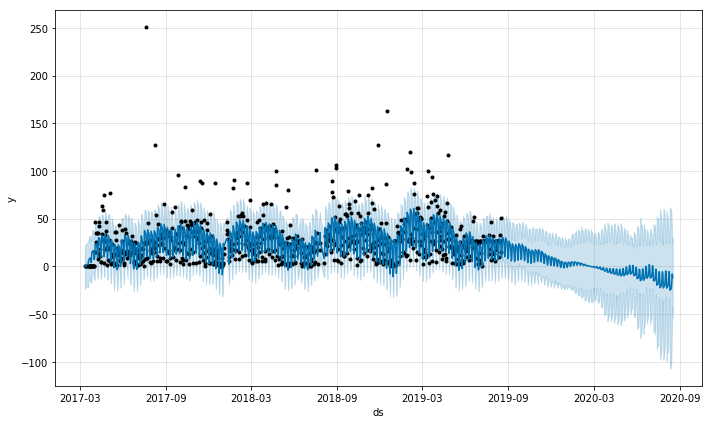

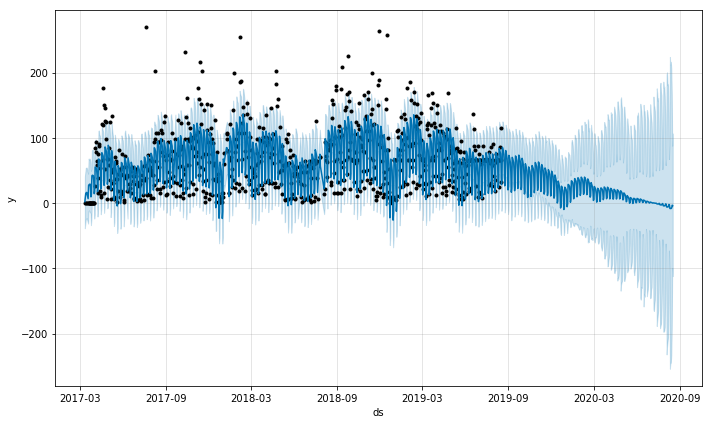

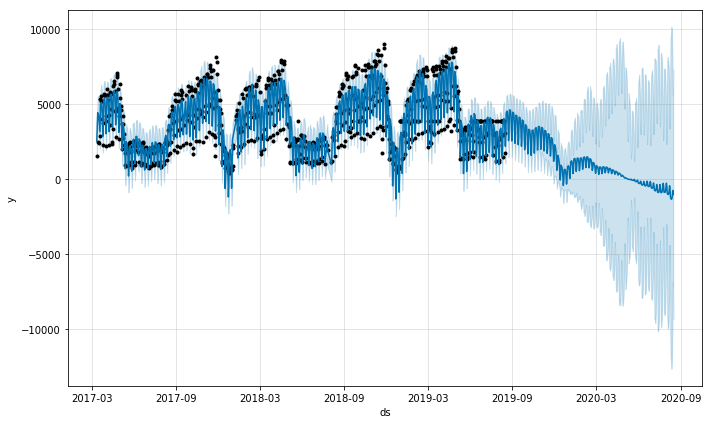

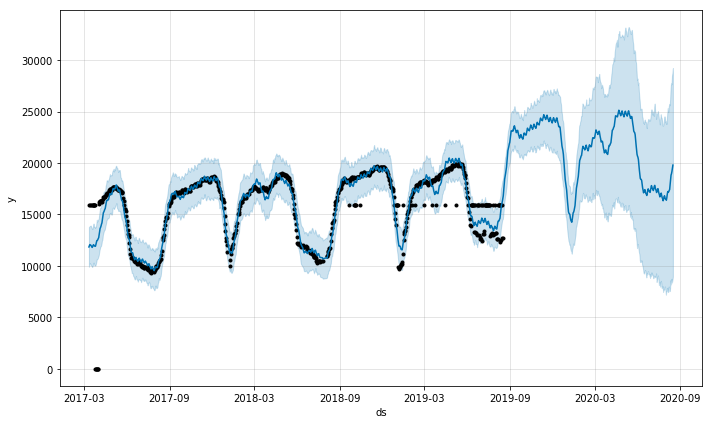

In [13]:
prediction = send_prediction(five_att)

The send_predictionMape function when a attributes are provided plot the mape error values across time.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for google_forms_created predictions
MAPE way too low to be graphed, prediction is very good


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for google_forms_edited predictions
MAPE way too low to be graphed, prediction is very good


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE for 1day_active_users predictions


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00


MAPE for 30day_active_users predictions


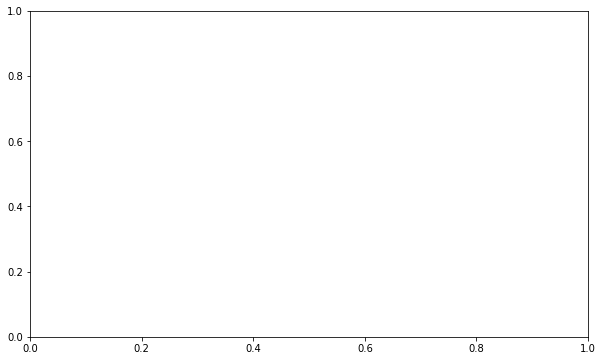

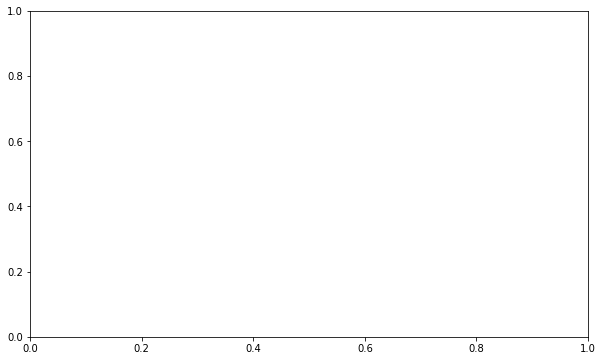

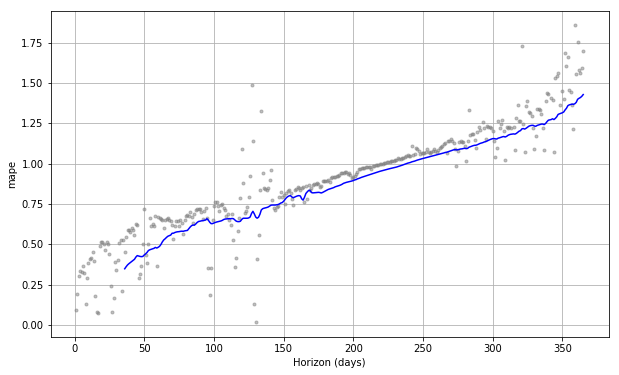

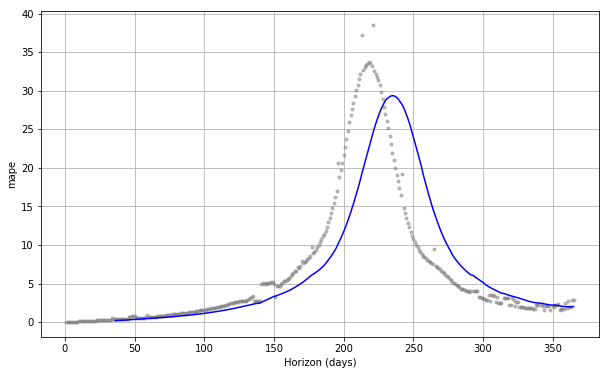

In [14]:
prediction1 = send_predictionMAPE(five_att)


From the above predictions and the mape errors we can see that the predictions folllows similar patterns and trends as the current available data. The mape error shows that the predictions in the initial days of prediction is more accurate than the final days of the prediction. 

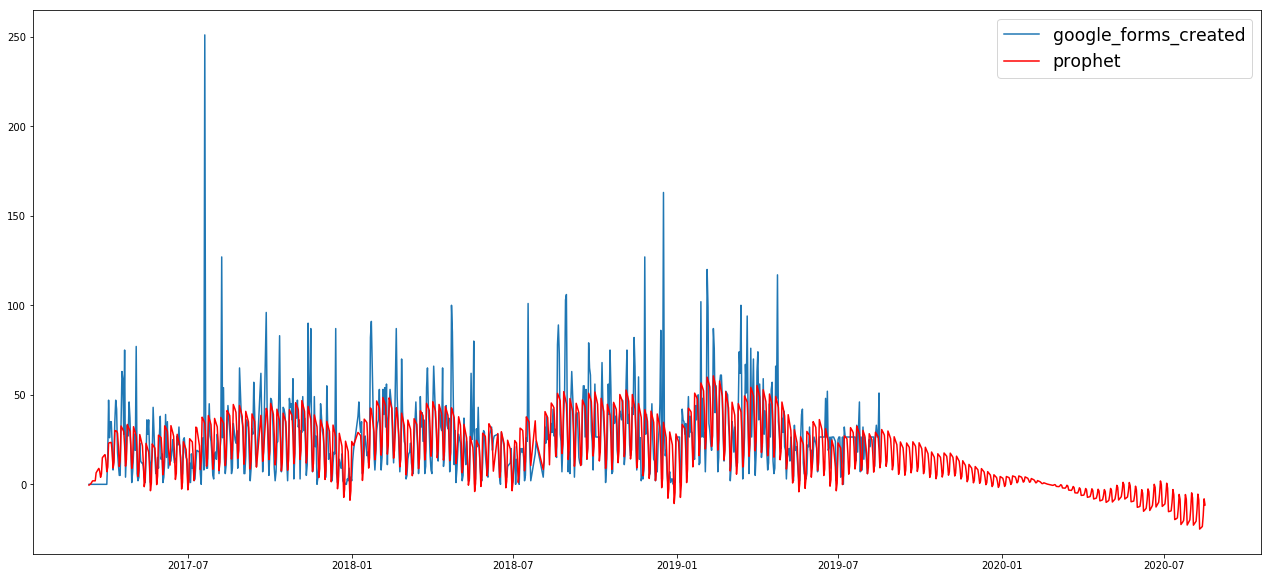

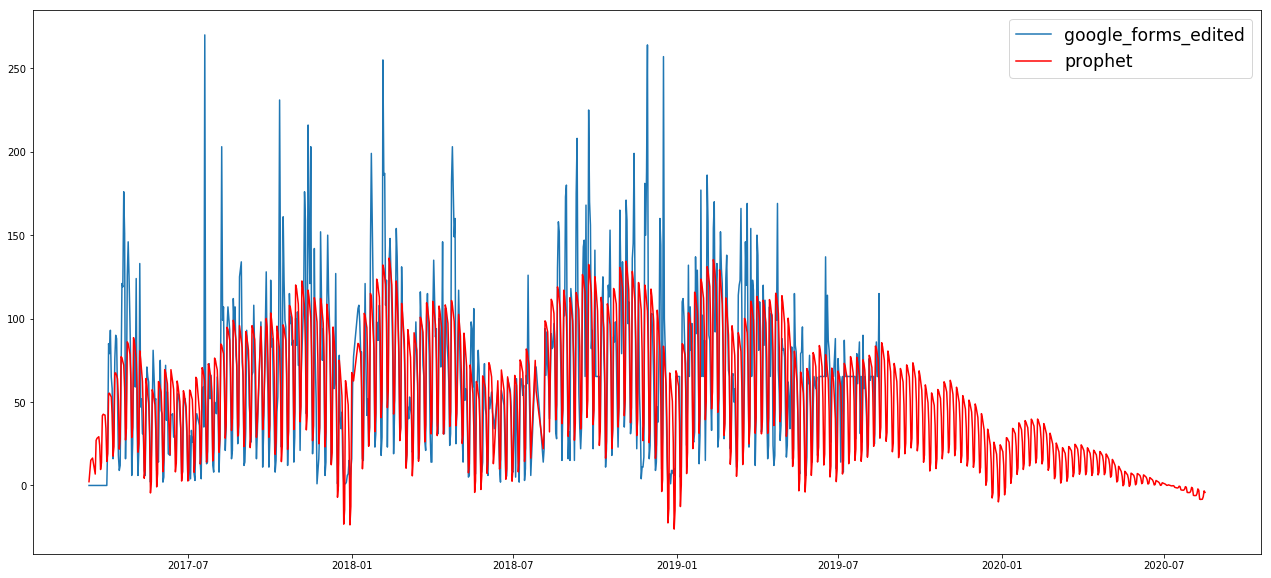

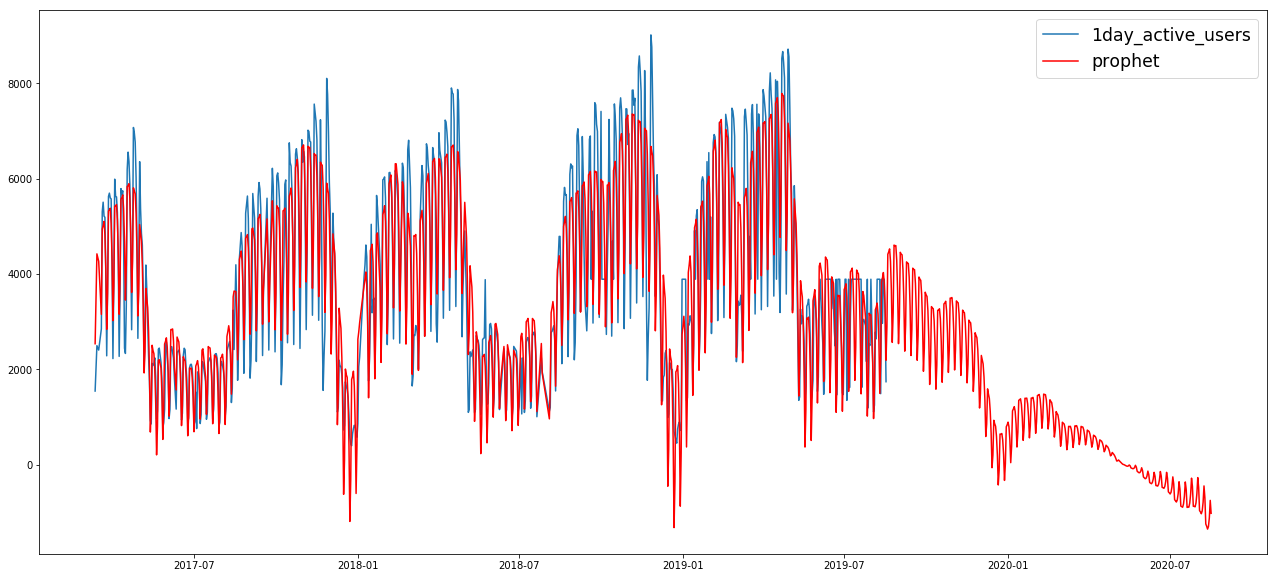

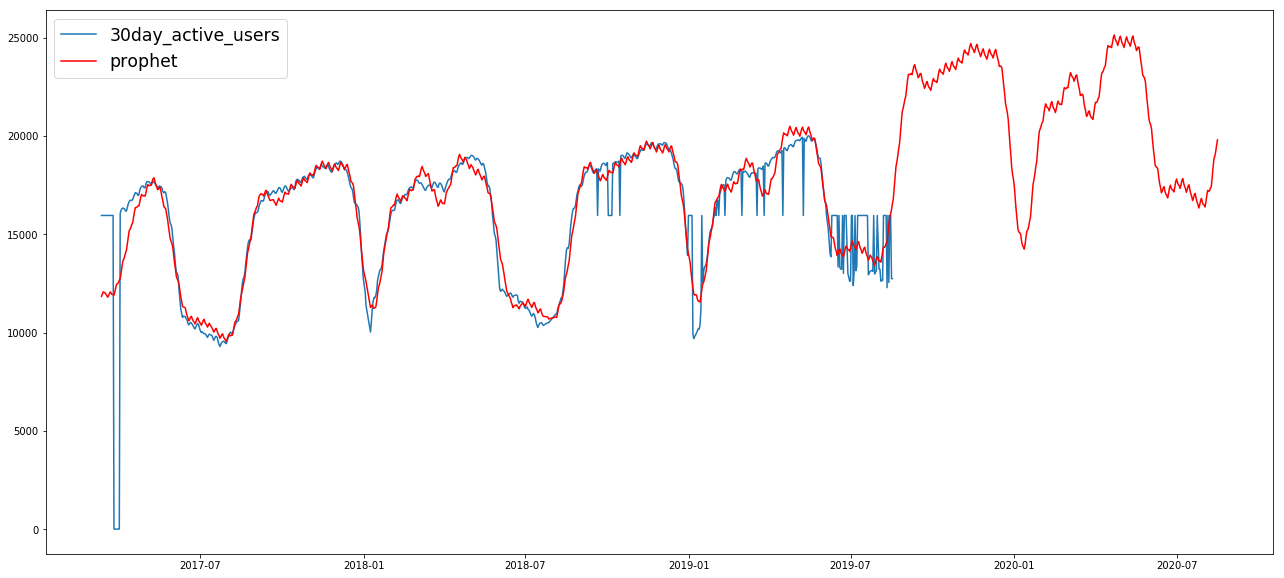

In [15]:
plot(five_att,prediction)

In [16]:
prediction

,time,google_forms_created,google_forms_edited,1day_active_users,30day_active_users
0,2017-03-12,-0.430970,2.257448,2536.031583,11841.085243
1,2017-03-14,0.268981,15.072758,4420.806798,12069.931256
2,2017-03-16,1.917188,16.421074,4265.215938,12019.552882
3,2017-03-19,1.963986,6.824772,3151.410971,11796.214199
4,2017-03-20,6.435084,26.999055,4944.922844,11880.273600
5,2017-03-21,7.313269,28.253957,5012.287100,12001.124716
6,2017-03-22,8.138500,28.692972,5101.356780,12067.736315
7,2017-03-23,8.879448,29.200432,4816.823507,11976.832182
8,2017-03-24,7.311217,23.962066,4106.582914,11928.623256
9,2017-03-25,3.935496,9.551966,2837.330096,11931.081672


In [17]:
five_att= pick_your_poison(2)

you picked the entire data set


In [ ]:
prediction1 = send_prediction(five_att)

In [ ]:
plot(five_att,prediction1)

In [18]:
df1= data[['time','google_forms_created']]
df1 = df1.rename(columns={df1.columns[0]: "ds", df1.columns[1]: "y"})

In [19]:
df1.head()

,ds,y
0,2017-03-12 05:00:00,0.0
1,2017-03-14 04:00:00,0.0
2,2017-03-16 04:00:00,0.0
3,2017-03-19 04:00:00,0.0
4,2017-03-20 04:00:00,0.0


In [20]:
m=Prophet()
m.fit(df1)

In [21]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1191,2020-08-12 04:00:00
1192,2020-08-13 04:00:00
1193,2020-08-14 04:00:00
1194,2020-08-15 04:00:00
1195,2020-08-16 04:00:00


In [22]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1191,2020-08-12 04:00:00,37.957420,14.218860,61.040867
1192,2020-08-13 04:00:00,36.923810,15.283050,60.233274
1193,2020-08-14 04:00:00,27.139006,3.969580,49.471098
1194,2020-08-15 04:00:00,12.612219,-9.885318,35.377476
1195,2020-08-16 04:00:00,17.499330,-6.102043,40.297086


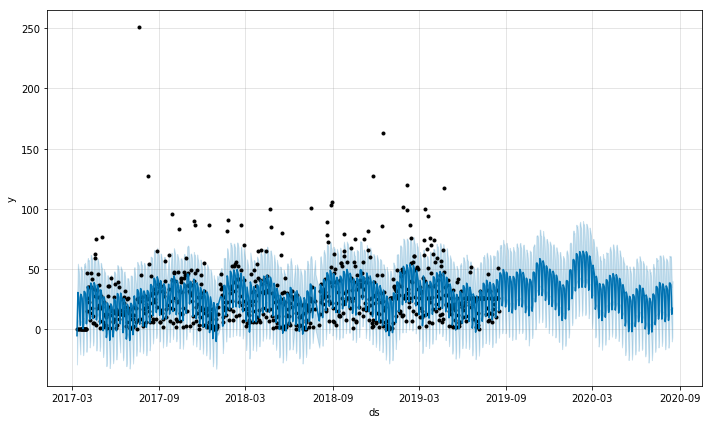

In [23]:
fig1 = m.plot(forecast)

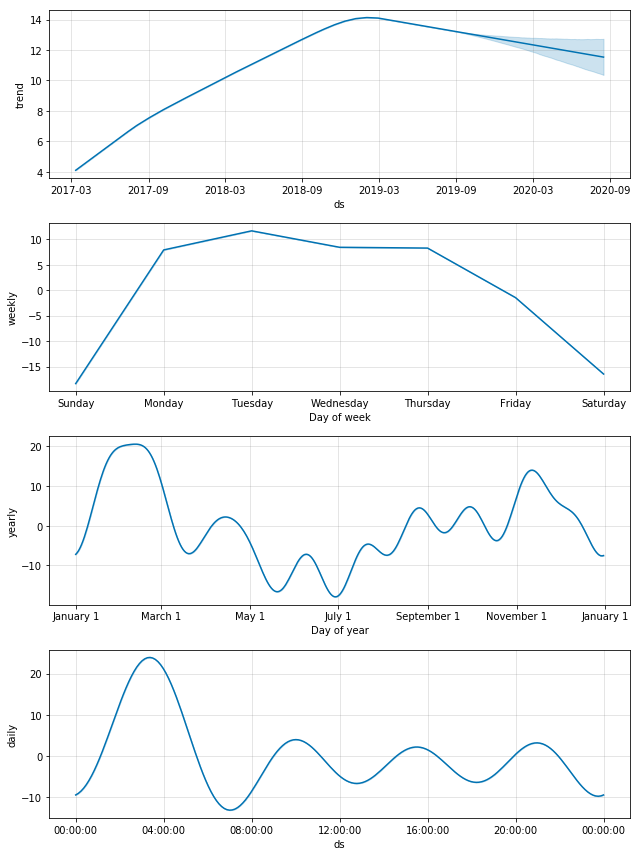

In [24]:
fig2 = m.plot_components(forecast)

In [ ]:
cross_validation_results = cross_validation(m, initial='210 days', period='15 days', horizon='70 days')
print(cross_validation_results)

In [ ]:
prediction=prediction.to_csv( 'forms_created_and_edited_prediction.csv', index = False)